# An example of motion tracking

In this short notebook, we will see how to track a mouse in a video, extract its coordinates and plot them on a graph.

For this example we will use this video, taken from the [OpenBehaviour](https://edspace.american.edu/openbehavior/) project (I have cropped the video to reduce its size, but you can find a lot of other examples on the site).

We will use the `av` (av stands for audio-video) library to read the video (you can `pip install av` to install it if needed).

In [208]:
import av
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, label2rgb
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops_table
from skimage.morphology import remove_small_objects
from tqdm import tqdm
import pandas as pd

In [209]:
# When opening a video in av we get a container, which is a list of streams. 
# We will use the first video stream (our video has only 1 stream, but we could have more).

container = av.open("mouse_tracking_short.mp4")
video = container.streams.video[0]

# We can see the information about the video stream
# The video is 640x480 pixels and in the yuv420p format (which is a common format for video)
print(f"Video: {video.width}x{video.height} pixels. Format: {video.format.name}")

Video: 640x480 pixels. Format: yuv420p


Now that we have the video, we can use the `decode` function to read it frame by frame. This function returns a generator, so we can use `next` to get each successive frame.

(480, 640, 3)


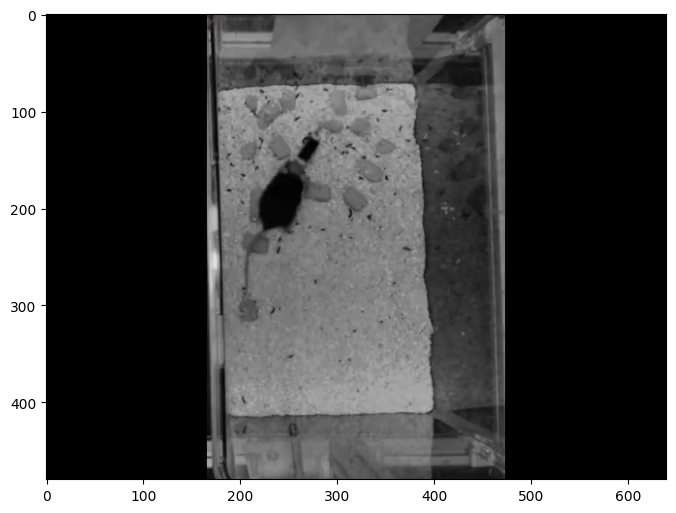

In [210]:
frames = container.decode(video)

# Get the first frame
frame0 = next(frames)

# Convert the frame to a numpy array
frame0 = np.array(frame0.to_image())

print(frame0.shape) # As expected this is 480 x 640 x 3 (RGB)

# Plot the image
fig, ax = plt.subplots(figsize = (8, 9))
ax.imshow(frame0)
plt.show()

The mouse is dark and it's fairly easy to separate it from the background.
I have used a manual thresholding to separate the mouse from the background, since in this case Otsu's thresholding gave poor results.

We are also going to crop the image to remove the black borders.

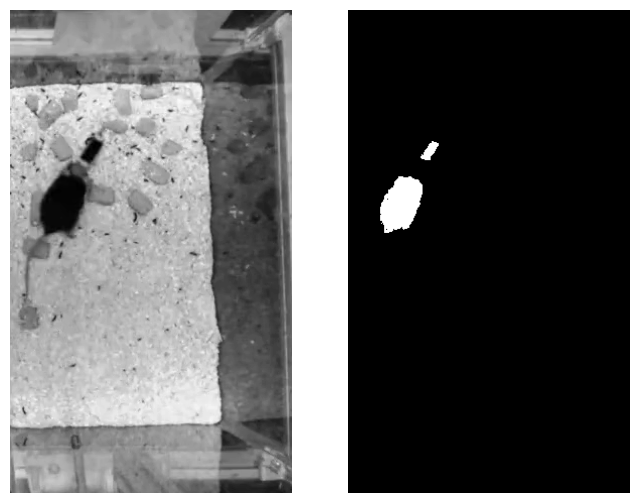

In [223]:
img_gray = rgb2gray(frame0)
# Crop
img_gray = img_gray[:, 190:470]
img_thresh = img_gray < 0.04

fig, ax = plt.subplots(ncols = 2, figsize = (8, 18))
ax[0].imshow(img_gray, cmap = "gray")
ax[0].axis("off")
ax[1].imshow(img_thresh, cmap = "gray")
ax[1].axis("off")

plt.show()

We can see that two main areas are highlighted, the mouse and the electrode holder on its head. We can use the `label` function to separate the two areas.

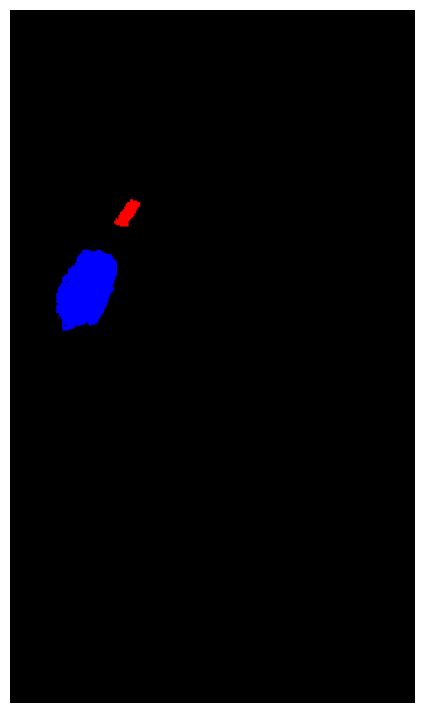

3


In [224]:
labels = label(img_thresh)

fig, ax = plt.subplots(figsize = (8, 9))
ax.imshow(label2rgb(labels))
ax.axis("off")
plt.show()

# Check how many labels we have. We expect 3, one for the mouse, one for the cup and one for the background
print(len(np.unique(labels)))


This looks good and we have the right number of objects. We can use the `remove_small_objects` function with a fairly large area to remove the electrode holder. This will also get rid of any small speckles.

2


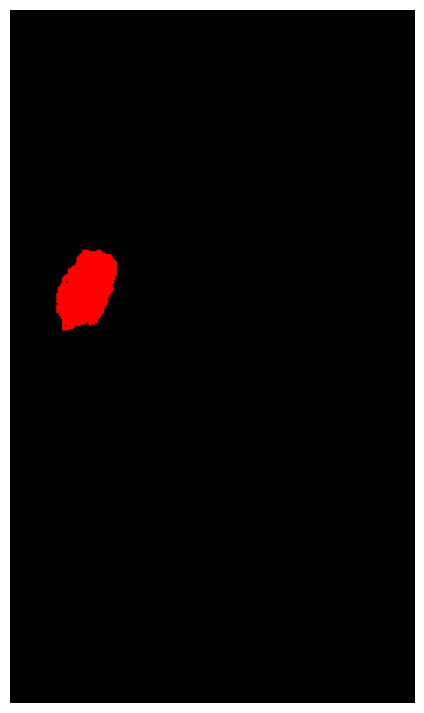

In [226]:
# I found the threshold (150) manually, but this could be automated by finding the areas of the
# various objects and using a threshold between the first and second largest areas
img_thresh = remove_small_objects(img_thresh, min_size = 450)
labels = label(img_thresh)

# Now we only expect 2 labels, one for the mouse, one for the background
print(len(np.unique(labels)))

fig, ax = plt.subplots(figsize = (8, 9))
ax.imshow(label2rgb(labels))
ax.axis("off")
plt.show()

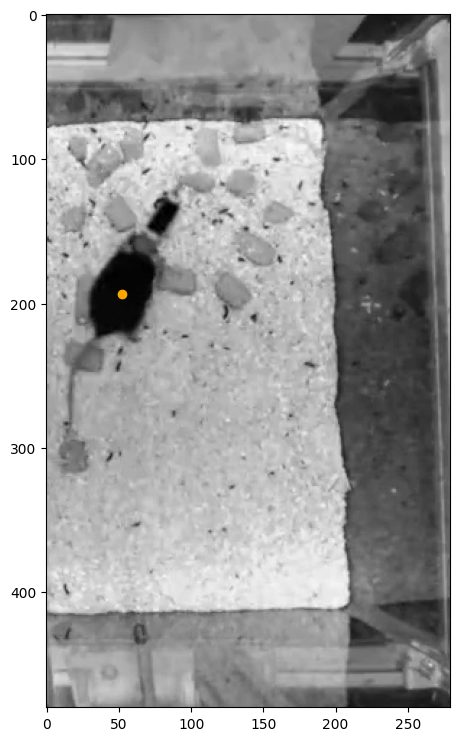

In [227]:
centroids = regionprops_table(labels, properties = ["centroid"])
x, y = centroids.values()
# Draw the centroids over the image
fig, ax = plt.subplots(figsize = (8, 9))
ax.imshow(img_gray, cmap = "gray")
ax.scatter(y, x, color = ["orange"])

We can now put everything in a for loop to process all the frames of the video.

In [231]:
# This list will contain the centroids for each frame
centroids = pd.DataFrame(columns = ["x", "y"])
container = av.open("mouse_tracking_short.mp4")
video = container.streams.video[0]
frames = container.decode(video)

for f in frames:
    if f.index % 50 == 0: # Print the progress every 50 frames
        print(f"Processing frame {f.index}")
    frame = np.array(f.to_image())
    img_gray = rgb2gray(frame)
    img_gray = img_gray[:, 190:470]
    img_thresh = img_gray < 0.04
    img_thresh = remove_small_objects(img_thresh, min_size = 350)
    labels = label(img_thresh)
    # Here, if necessary we could check that we have only 2 labels and only keep 
    # the largest one (the mouse)

    c = pd.DataFrame(regionprops_table(labels, properties = ["centroid"]))
    # Rename columns, for nicer names
    c.columns = ["x", "y"]
    centroids = pd.concat([centroids, c])

# This resets the index so that every row has a unique index, corresponding to the frame number
centroids.reset_index(inplace = True, drop = True) 

Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350


In [233]:
print(centroids)

              x          y
0    192.929688  52.274639
1    188.801212  53.849091
2    179.738762  56.093811
3    169.440903  58.706507
4    162.653951  63.509537
..          ...        ...
400  128.074759  32.346410
401  125.543296  31.655726
402  123.570629  30.423077
403  123.479720  29.577622
404  123.238742  29.384560

[405 rows x 2 columns]


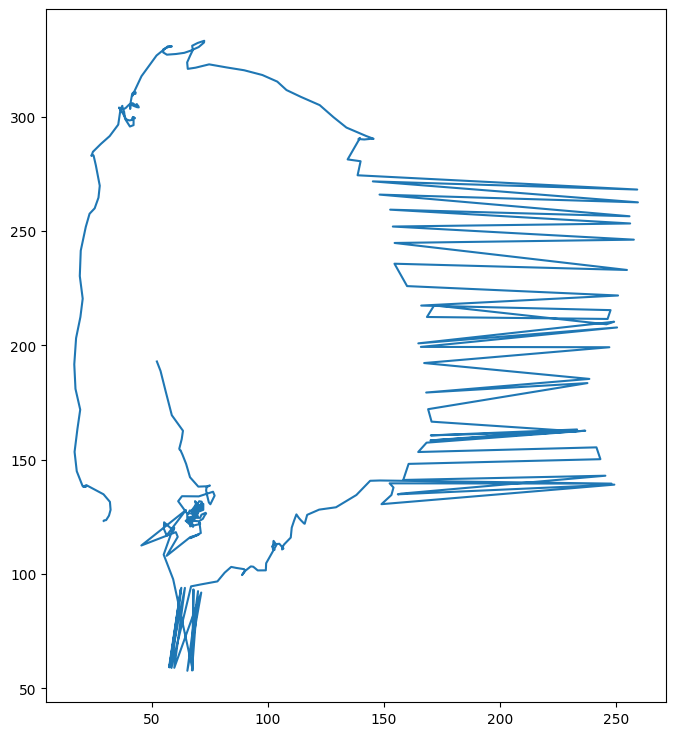

In [232]:
# Plot the trajectory
fig, ax = plt.subplots(figsize = (8, 9))
ax.plot(centroids["y"], centroids["x"])
plt.show()

Something strange is happening on the right and bottom side of the cage... This is likely a result of the reflection of the mouse being considered part of the mouse.

This is easy to remove by further cropping the image

Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350


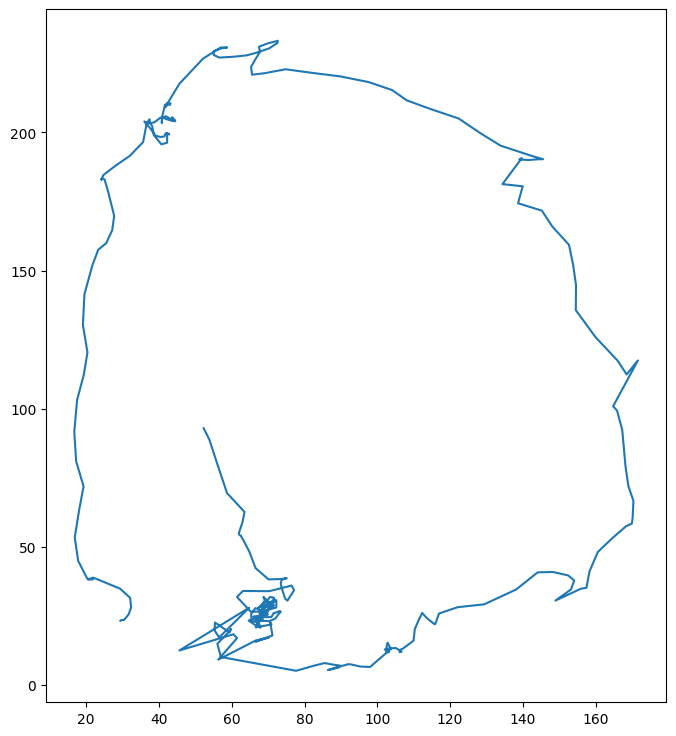

In [242]:
# This list will contain the centroids for each frame
centroids = pd.DataFrame(columns = ["x", "y"])
container = av.open("mouse_tracking_short.mp4")
video = container.streams.video[0]
frames = container.decode(video)

for f in frames:
    if f.index % 50 == 0: # Print the progress every 50 frames
        print(f"Processing frame {f.index}")
    frame = np.array(f.to_image())
    img_gray = rgb2gray(frame)
    img_gray = img_gray[100:, 190:380]
    img_thresh = img_gray < 0.04
    img_thresh = remove_small_objects(img_thresh, min_size = 350)
    labels = label(img_thresh)
    # Here, if necessary we could check that we have only 2 labels and only keep 
    # the largest one (the mouse)

    c = pd.DataFrame(regionprops_table(labels, properties = ["centroid"]))
    # Rename columns, for nicer names
    c.columns = ["x", "y"]
    centroids = pd.concat([centroids, c])

# This resets the index so that every row has a unique index, corresponding to the frame number
centroids.reset_index(inplace = True, drop = True) 

# Plot the trajectory
fig, ax = plt.subplots(figsize = (8, 9))
ax.plot(centroids["y"], centroids["x"])
plt.show()

And this is it! We can obviously improve this much more, but this is a good start and shows you how we can perform even quite complex operations using simple techniques.